--- Day 4: Ceres Search ---

"Looks like the Chief's not here. Next!" One of The Historians pulls out a device and pushes the only button on it. After a brief flash, you recognize the interior of the Ceres monitoring station!

As the search for the Chief continues, a small Elf who lives on the station tugs on your shirt; she'd like to know if you could help her with her word search (your puzzle input). She only has to find one word: XMAS.

This word search allows words to be horizontal, vertical, diagonal, written backwards, or even overlapping other words. It's a little unusual, though, as you don't merely need to find one instance of XMAS - you need to find all of them. Here are a few ways XMAS might appear, where irrelevant characters have been replaced with .:

..X...
.SAMX.
.A..A.
XMAS.S
.X....

The actual word search will be full of letters instead. For example:

MMMSXXMASM
MSAMXMSMSA
AMXSXMAAMM
MSAMASMSMX
XMASAMXAMM
XXAMMXXAMA
SMSMSASXSS
SAXAMASAAA
MAMMMXMMMM
MXMXAXMASX

In this word search, XMAS occurs a total of 18 times; here's the same word search again, but where letters not involved in any XMAS have been replaced with .:

....XXMAS.
.SAMXMS...
...S..A...
..A.A.MS.X
XMASAMX.MM
X.....XA.A
S.S.S.S.SS
.A.A.A.A.A
..M.M.M.MM
.X.X.XMASX

Take a look at the little Elf's word search. How many times does XMAS appear?


In [64]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

In [81]:
def read_grid_from_file(filename):
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    # Convert lines to a 2D array of chars
    grid = np.array([list(line) for line in lines], dtype='<U1')
    return grid

In [80]:
read_grid_from_file('test.txt')

array([['M', 'M', 'M', 'S', 'X', 'X', 'M', 'A', 'S', 'M'],
       ['M', 'S', 'A', 'M', 'X', 'M', 'S', 'M', 'S', 'A'],
       ['A', 'M', 'X', 'S', 'X', 'M', 'A', 'A', 'M', 'M'],
       ['M', 'S', 'A', 'M', 'A', 'S', 'M', 'S', 'M', 'X'],
       ['X', 'M', 'A', 'S', 'A', 'M', 'X', 'A', 'M', 'M'],
       ['X', 'X', 'A', 'M', 'M', 'X', 'X', 'A', 'M', 'A'],
       ['S', 'M', 'S', 'M', 'S', 'A', 'S', 'X', 'S', 'S'],
       ['S', 'A', 'X', 'A', 'M', 'A', 'S', 'A', 'A', 'A'],
       ['M', 'A', 'M', 'M', 'M', 'X', 'M', 'M', 'M', 'M'],
       ['M', 'X', 'M', 'X', 'A', 'X', 'M', 'A', 'S', 'X']], dtype='<U1')

In [88]:
print(grid)
print(grid.shape)  # Should be (10, 10)


[['M' 'M' 'M' 'S' 'X' 'X' 'M' 'A' 'S' 'M']
 ['M' 'S' 'A' 'M' 'X' 'M' 'S' 'M' 'S' 'A']
 ['A' 'M' 'X' 'S' 'X' 'M' 'A' 'A' 'M' 'M']
 ['M' 'S' 'A' 'M' 'A' 'S' 'M' 'S' 'M' 'X']
 ['X' 'M' 'A' 'S' 'A' 'M' 'X' 'A' 'M' 'M']
 ['X' 'X' 'A' 'M' 'M' 'X' 'X' 'A' 'M' 'A']
 ['S' 'M' 'S' 'M' 'S' 'A' 'S' 'X' 'S' 'S']
 ['S' 'A' 'X' 'A' 'M' 'A' 'S' 'A' 'A' 'A']
 ['M' 'A' 'M' 'M' 'M' 'X' 'M' 'M' 'M' 'M']
 ['M' 'X' 'M' 'X' 'A' 'X' 'M' 'A' 'S' 'X']]
(10, 10)


In [94]:
def find_word(grid, word="XMAS"):
    # Map each letter in "XMAS" to a numeric value
    # X=1, M=2, A=3, S=4 for consistency
    char_to_num = {'X':1, 'M':2, 'A':3, 'S':4}
    word_len = len(word)
    target_sum = sum(range(1, word_len+1))  # 1+2+3+4=10

    # Convert the character grid to a numeric grid
    binary_grid = np.zeros(grid.shape, dtype=int)
    for c, val in char_to_num.items():
        binary_grid[grid == c] = val

    # Forward kernels
    # Horizontal forward: X M A S
    kernel_h = np.array([char_to_num[c] for c in word]).reshape(1, -1)
    # Vertical forward: transpose of horizontal
    kernel_v = kernel_h.T
    # Diagonal forward
    kernel_d = np.zeros((word_len, word_len), dtype=int)
    for i, c in enumerate(word):
        kernel_d[i, i] = char_to_num[c]
    # Anti-diagonal forward
    kernel_ad = np.fliplr(kernel_d)

    # Reversed kernels (for "SAMX"), created by flipping the forward kernels
    # Horizontal reversed
    kernel_h_rev = kernel_h[:, ::-1]
    # Vertical reversed
    kernel_v_rev = kernel_v[::-1, :]
    # Diagonal reversed: create from reversed word order
    reversed_word = word[::-1]  # "SAMX"
    kernel_d_rev = np.zeros((word_len, word_len), dtype=int)
    for i, c in enumerate(reversed_word):
        kernel_d_rev[i, i] = char_to_num[c]
    kernel_ad_rev = np.fliplr(kernel_d_rev)

    # Helper function to count matches for a given kernel
    def count_matches(kernel):
        conv_res = convolve2d(binary_grid, kernel, mode='valid')
        return np.count_nonzero(conv_res == target_sum)

    # Count occurrences in all 8 directions
    matches = 0
    matches += count_matches(kernel_h)      # horizontal forward
    matches += count_matches(kernel_h_rev)  # horizontal backward
    matches += count_matches(kernel_v)      # vertical down
    matches += count_matches(kernel_v_rev)  # vertical up
    matches += count_matches(kernel_d)      # diagonal (top-left to bottom-right)
    matches += count_matches(kernel_d_rev)  # diagonal reversed
    matches += count_matches(kernel_ad)     # anti-diagonal
    matches += count_matches(kernel_ad_rev) # anti-diagonal reversed

    return matches

In [90]:
def visualize_matches(grid, match_grid):
    """
    Visualizes the matches on the grid using matplotlib.
    
    Parameters:
        grid (np.ndarray): The original grid of characters.
        match_grid (np.ndarray): The grid highlighting matches.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Display the original grid
    ax.imshow(match_grid, cmap="cool", alpha=0.7)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            color = "red" if match_grid[i, j] else "black"
            ax.text(j, i, grid[i, j], ha="center", va="center", color=color, fontsize=10)

    ax.set_xticks([])
    ax.set_yticks([])
    plt.title("XMAS Matches Visualization", fontsize=14)
    plt.show()


In [96]:
# Assume the word search is saved in 'wordsearch.txt'
grid = read_grid_from_file('test.txt')
total_occurrences = find_word(grid, "XMAS")
print("Total occurrences of 'XMAS':", total_occurrences)

Total occurrences of 'XMAS': 0


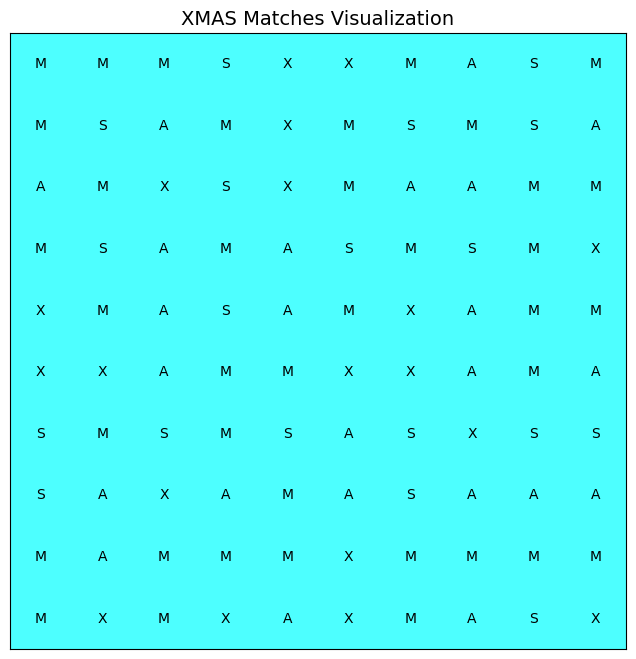

In [97]:
# Visualize the matches
match_grid = np.zeros(grid.shape, dtype=int)
find_word(grid, "XMAS")
visualize_matches(grid, match_grid)

In [102]:
import numpy as np

def read_grid_from_file(filename):
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    grid = np.array([list(line) for line in lines], dtype='<U1')
    return grid

def in_bounds(x, y, rows, cols):
    return 0 <= x < rows and 0 <= y < cols

def find_all_occurrences(grid, word="XMAS"):
    rows, cols = grid.shape
    word_len = len(word)

    # We also consider the reversed version of the word
    rev_word = word[::-1]

    # Define all 8 directions: (dx, dy)
    directions = [
        (0, 1),   # horizontal left-to-right
        (0, -1),  # horizontal right-to-left
        (1, 0),   # vertical top-to-bottom
        (-1, 0),  # vertical bottom-to-top
        (1, 1),   # diagonal top-left to bottom-right
        (-1, -1), # diagonal bottom-right to top-left
        (1, -1),  # diagonal top-right to bottom-left
        (-1, 1)   # diagonal bottom-left to top-right
    ]

    count = 0
    for x in range(rows):
        for y in range(cols):
            # If the current cell matches the first letter of `word` or `rev_word`,
            # then try in each direction.
            current_char = grid[x, y]

            # If current char isn't the start of "XMAS" or "SAMX", skip
            if current_char not in (word[0], rev_word[0]):
                continue

            for dx, dy in directions:
                # Check forward word
                # Collect characters in this direction
                forward_chars = []
                for i in range(word_len):
                    nx, ny = x + i*dx, y + i*dy
                    if in_bounds(nx, ny, rows, cols):
                        forward_chars.append(grid[nx, ny])
                    else:
                        break
                if ''.join(forward_chars) == word:
                    count += 1
                elif ''.join(forward_chars) == rev_word:
                    count += 1

    return count

if __name__ == "__main__":
    grid = read_grid_from_file("in.txt")
    total = find_all_occurrences(grid, "XMAS")
    print("Total occurrences of 'XMAS':", total / 2)
    

Total occurrences of 'XMAS': 2685.0


In [104]:
import numpy as np

def read_grid_from_file(filename):
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    grid = np.array([list(line) for line in lines], dtype='<U1')
    return grid

def in_bounds(x, y, rows, cols):
    return 0 <= x < rows and 0 <= y < cols

def is_mas_or_sam(a, b, c):
    # Check if sequence [a, b, c] is either MAS or SAM
    return (a == 'M' and b == 'A' and c == 'S') or (a == 'S' and b == 'A' and c == 'M')

def count_xmas(grid):
    rows, cols = grid.shape
    count = 0

    # For each cell, consider it as the center of X-MAS if it's 'A'
    for x in range(rows):
        for y in range(cols):
            if grid[x, y] != 'A':
                continue

            # Coordinates for diagonals:
            # Main diagonal: (x-1,y-1), (x,y), (x+1,y+1)
            # Anti-diagonal: (x-1,y+1), (x,y), (x+1,y-1)

            # Check bounds for main diagonal
            if (in_bounds(x-1, y-1, rows, cols) and in_bounds(x+1, y+1, rows, cols)):
                main_diag = [grid[x-1, y-1], grid[x, y], grid[x+1, y+1]]
            else:
                main_diag = None

            # Check bounds for anti-diagonal
            if (in_bounds(x-1, y+1, rows, cols) and in_bounds(x+1, y-1, rows, cols)):
                anti_diag = [grid[x-1, y+1], grid[x, y], grid[x+1, y-1]]
            else:
                anti_diag = None

            # Both diagonals must be valid and form MAS/SAM
            if main_diag and anti_diag:
                if is_mas_or_sam(*main_diag) and is_mas_or_sam(*anti_diag):
                    count += 1

    return count

if __name__ == "__main__":
    grid = read_grid_from_file("in.txt")
    total_xmas = count_xmas(grid)
    print("Total occurrences of X-MAS:", total_xmas)


Total occurrences of X-MAS: 2048
